## Сбалансированное АВЛ-дерево

https://stepik.org/lesson/41563/step/1

- [--] обход inorder, preorder, postorder (рекурсия)
- [--] обход inorder, preorder, postorder (итеративный)
- [--] обход в глубину (рекурсия и итеративный)
- [--] обход в ширину (рекурсия и итеративный)
- [+]  поиск минимума, максимума
- [+]  поиск предыдущего, следующего
- [--] поиск высоты: рекурсивно, стеком
- [+]  поиск высоты: кешами
- [+]  АВЛ: пересчет кеша высоты, вставка, удаление
- [+]  АВЛ: левое/правое большое/малое вращение
- [--] обращение по индексу
- [--] размер поддерева (и пересчет кеша)
- [+] разрезание, склеивание
- [--] полный пересчет кешей
- [+]  проверка корректности

In [1]:
%matplotlib inline
from IPython.display import Image, HTML
from IPython.core.debugger import set_trace as trace

In [10]:
from collections import Iterable

class AvlNode:
    def __init__(self, key=None):
        self.key = key
        self._clear()

    def _clear(self):
        self.left = self.right = None
        self.parent = None
        self.height = 0

    @property
    def label(self):
        marker1, marker2 = '[', ']'
        if self.parent:
            if self == self.parent.left and not self.parent.right:
                marker1, marker2 = '[', '...'
            if self == self.parent.right and not self.parent.left:
                marker1, marker2 = '...', ']'
        return '{}\n{}{}{}'.format(
            self.key, marker1, self.height, marker2)

    def __repr__(self):
        return '["{}" ({}) {},{}]'.format(
            self.key, self.height,
            '.' if self.left is None else self.left.key,
            '.' if self.right is None else self.right.key,
        )

    @property
    def left_height(self):
        return self.left.height if self.left else -1

    @property
    def right_height(self):
        return self.right.height if self.right else -1

    def _update_height(self):
        old_h = self.height
        self.height = 1 + max(self.left_height, self.right_height)
        return self.height != old_h

    
class AvlTree:
    width = 0.7
    node_color = 'lightgray'
    node_size = 1600
    vgap = .2
    _debug = False

    def debug(*a, **kw):
        if self._debug:
            print(*a, **kw)

    def __repr__(self):
        def walk(node):
            if node:
                yield '[{} {} {}]'.format(
                    node.key,
                    '.' if node.left is None else node.left.key,
                    '.' if node.right is None else node.right.key)
                yield from walk(node.left)
                yield from walk(node.right)
        return '[' + ''.join(walk(self.root)) + ']'

    def draw(self, node_color=None, node_size=None, width=None, **kw):
        from networkx import Graph, draw
        from operator import attrgetter

        width = width or self.width
        vgap = self.vgap
        vloc = 0
        xcenter = width / 2
        node_color = node_color or self.node_color
        node_size = node_size or self.node_size

        if self.root is None:
            return

        def add_graph_node(node):
            if node not in graph.nodes:
                graph.add_node(node)
                labels[node] = node.label
            left = node.left
            if left is not None:
                add_graph_node(left)
                graph.add_edge(node, left)
            right = node.right
            if right is not None:
                add_graph_node(right)
                graph.add_edge(node, right)

        graph = Graph()
        labels = {}
        add_graph_node(self.root)

        def layout_hier(root, width, vloc, xcenter, pos=None, parent=None):
            if pos is None:
                pos = { root: (xcenter, vloc) }
            else:
                pos[root] = (xcenter, vloc)
            neighbors = list(graph.neighbors(root))
            if parent is not None:
                neighbors.remove(parent)
            if len(neighbors):
                dx = width / len(neighbors) 
                nextx = xcenter - width/2 - dx/2
                for neighbor in sorted(neighbors, key=attrgetter('key')):
                    nextx += dx
                    pos = layout_hier(neighbor, width=dx, vloc=vloc-vgap, xcenter=nextx,
                                      pos=pos, parent=root)
            return pos

        return draw(graph,
                    pos=layout_hier(self.root, width, vloc, xcenter),
                    with_labels=True, labels=labels,
                    node_color=node_color, node_size=node_size,
                    **kw)

    def __init__(self, tree=None):
        if isinstance(tree, str):
            self.parse(tree)
        elif isinstance(tree, Iterable):
            self.root = None
            self.add(tree)
        else:
            self.root = tree
            if tree:
                tree.parent = None

    def find(self, key):
        node, found = self.find_node(key)
        return found

    def add(self, keys):
        if not isinstance(keys, (str, Iterable)):
            keys = [keys]
        for key in keys:
            self.add_node(AvlNode(key))
        return self

    def remove(self, keys):
        if not isinstance(keys, (str, Iterable)):
            keys = [keys]
        for key in keys:
            node, found = self.find_node(key)
            if found:
                self.remove_node(node)
        return self

    def find_node(self, key):
        node = parent = self.root
        while node:
            parent = node
            if key > node.key:
                node = node.right
            elif key < node.key:
                node = node.left
            else:
                assert key == node.key
                return node, True
        assert not (parent.left and parent.right)
        return parent, False
    
    def add_node(self, node):
        if not node:
            return False
        if not self.root:
            self.root = node
            node.parent = None
            return True
        parent, found = self.find_node(node.key)
        if found:
            return False
        if parent.key > node.key:
            parent.left = node
        else:
            parent.right = node
        node.parent = parent
        self._rebalance(parent)
        return True

    def remove_node(self, node):
        if not node:
            return
        if node.left and node.right:
            # two children
            orig = node
            node = node.left
            while node.right:
                node = node.right
            node.key, orig.key = orig.key, node.key
            self.remove_node(node)
        else:
            # one child or no children
            parent = node.parent
            child = node.left or node.right
            self._replace_child(node, child)
            node._clear()
            self._rebalance(parent)
        return node

    def _replace_child(self, old_node, new_node):
        parent = old_node.parent
        old_node.parent = None
        if parent is None:
            assert self.root == old_node
            self.root = new_node
            if new_node:
                new_node.parent = None
            return None
        if old_node == parent.left:
            parent.left = new_node
            if new_node:
                new_node.parent = parent
            return True
        elif old_node == parent.right:
            parent.right = new_node
            if new_node:
                new_node.parent = parent
            return False
        else:
            raise RuntimeError('tree broken')

    def _rebalance(self, node, force=False):
        while node:
            left_h = node.left_height
            right_h = node.right_height
            # см. описание:  https://stepik.org/lesson/41563/step/3
            if right_h - left_h > 1:
                beta = node.right
                gamma = beta.left
                if beta.right_height > left_h:
                    # малое правое вращение
                    node.right = gamma
                    if gamma:
                        gamma.parent = node
                    beta.left = node
                    self._replace_child(node, beta)
                    node.parent = beta
                else:
                    # большое правое вращение
                    assert gamma is not None
                    node.right = gamma.left
                    if node.right:
                        node.right.parent = node
                    beta.left = gamma.right
                    if beta.left:
                        beta.left.parent = beta
                    gamma.right = beta
                    beta.parent = gamma
                    beta._update_height()
                    self._replace_child(node, gamma)
                    gamma.left = node
                    node.parent = gamma
                    node.height = -1  # force update
            elif left_h - right_h > 1:
                beta = node.left
                gamma = beta.right
                if beta.left_height > right_h:
                    # малое левое вращение
                    node.left = gamma
                    if gamma:
                        gamma.parent = node
                    beta.right = node
                    self._replace_child(node, beta)
                    node.parent = beta
                else:
                    # большое правое вращение
                    assert gamma is not None
                    node.left = gamma.right
                    if node.left:
                        node.left.parent = node
                    beta.right = gamma.left
                    if beta.right:
                        beta.right.parent = beta
                    gamma.left, beta.parent = beta, gamma
                    beta._update_height()
                    self._replace_child(node, gamma)
                    gamma.right = node
                    node.parent = gamma
                    node.height = -1  # force update
            if not (node._update_height() or force):
                break
            node = node.parent

    def invalid_node(self):
        node = self.root
        stack = []
        val = None
        while node or stack:
            if node:
                stack.append(node)
                node = node.left
                continue
            node = stack.pop()
            if val is None or node.key > val:
                val = node.key
                node = node.right
                continue
            else:
                return node
        return None

    @property
    def height(self):
        return self.root.height if self.root else -1
    
    @property
    def is_valid(self):
        return self.invalid_node() is None

    @property
    def is_balanced(self):
        node = self.root
        stack = []
        while node or stack:
            node = node or stack.pop()
            if abs(node.left_height - node.right_height) > 1:
                return False
            if node.right:
                stack.append(node.right)
            node = node.left
        return True

    def _get_min_node(self):
        parent = node = self.root
        while node:
            parent, node = node, node.left
        return parent

    def _get_max_node(self):
        parent = node = self.root
        while node:
            parent, node = node, node.right
        return parent

    @property
    def min(self):
        node = self._get_min_node()
        return node.key if node else None

    @property
    def max(self):
        node = self._get_max_node()
        return node.key if node else None

    def next_node(self, node):
        if node.right:
            node = node.right
            while node.left:
                node = node.left
            return node
        while node:
            parent = node.parent
            if not parent:
                break
            if node == parent.left:
                return parent
            node = parent
        return None

    def prev_node(self, node):
        if node.left:
            node = node.left
            while node.right:
                node = node.right
            return node
        while node:
            parent = node.parent
            if not parent:
                break
            if node == parent.right:
                return parent
            node = parent
        return None

    def next(self, key):
        node, found = self.find_node(key)
        node = self.next_node(node) if found else None
        return node.key if node else None
    
    def prev(self, key):
        node, found = self.find_node(key)
        node = self.prev_node(node) if found else None
        return node.key if node else None

    def _append_tree(self, tree, top=None):
        # https://stepik.org/lesson/45920/step/3
        if not (tree and tree.root):
            self.add_node(top)
            return
        height, my_height = tree.height, self.height
        assert height <= my_height
        if not top:
            top = tree._get_min_node()
            assert self.max < top.key
            tree.remove_node(top)
            height = tree.height
        subtop = tree.root
        tree.root = None
        node = parent = self.root
        if abs(height - my_height) < 2 or subtop is None:
            self.root = top
            top.parent = None
            top.left = node
            top.right = subtop
            node.parent = top
            if subtop is None:
                self._rebalance(node)
            else:
                subtop.parent = top
            top._update_height()
            return
        while node and abs(height + 1 - node.height) > 1:
            node, parent = node.right, node
        assert node is not None, 'big diff {} vs {} vs {}'.format(
                            height, parent.height, self.root.height)
        top.right = subtop
        if subtop:
            subtop.parent = top
        subtree = node.right
        top.left = subtree
        if subtree:
            subtree.parent = top
        node.right, top.parent = top, node
        self._rebalance(top, force=True)

    def _prepend_tree(self, tree, top=None):
        if not (tree and tree.root):
            self.add_node(top)
            return
        height, my_height = tree.height, self.height
        assert height <= my_height
        if not top:
            top = tree._get_max_node()
            assert self.min > top.key
            tree.remove_node(top)
            height = tree.height
        subtop = tree.root
        tree.root = None
        node = parent = self.root
        if abs(height - my_height) < 2 or subtop is None:
            self.root = top
            top.parent = None
            top.left = subtop
            top.right = node
            node.parent = top
            if subtop is None:
                self._rebalance(top)
            else:
                subtop.parent = top
            top._update_height()
            return
        while node and abs(height + 1 - node.height) > 1:
            node, parent = node.left, node
        assert node is not None, 'big diff {} vs {} vs {}'.format(
                            height, parent.height, self.root.height)
        top.left = subtop
        if subtop:
            subtop.parent = top
        subtree = node.left
        top.right = subtree
        if subtree:
            subtree.parent = top
        node.left, top.parent = top, node
        self._rebalance(top, force=True)

    def merge_tree(self, tree, top=None):
        if not (tree and tree.root):
            self.add_node(top)
        elif not self.root:
            tree.root, self.root = None, tree.root
            self.add_node(top)
        elif tree.height > self.height:
            tree._prepend_tree(self, top)
            tree.root, self.root = None, tree.root
        else:
            self._append_tree(tree, top)
        return self

    def split(self, key, traceme=0):
        if traceme:
            trace()
        root = self.root
        if not root:
            return self, AvlTree()
        self.root = None
        left, right = AvlTree(root.left), AvlTree(root.right)
        root._clear()
        if key < root.key:
            ltree, rtree = left.split(key)
            rtree.merge_tree(right, root)
            return ltree, rtree
        else:
            ltree, rtree = right.split(key)
            left.merge_tree(ltree, root)
            return left, rtree


## Split/Merge Test

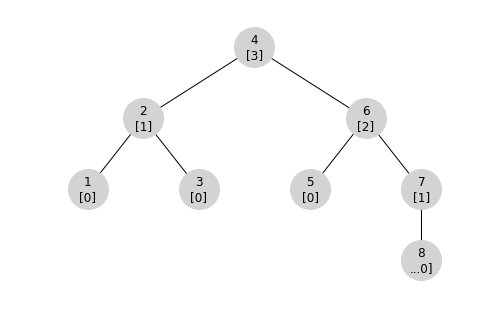

In [11]:
st1 = AvlTree(range(1,9))
st2 = st3 = None
st1.draw()

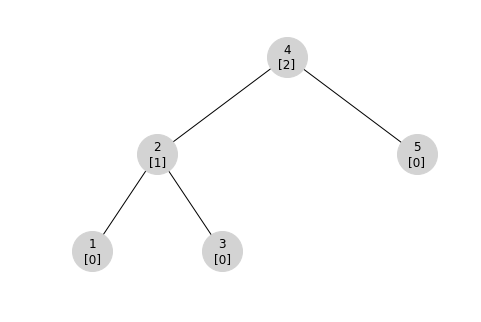

In [12]:
st2, st3 = st1.split(5)
st2.draw()

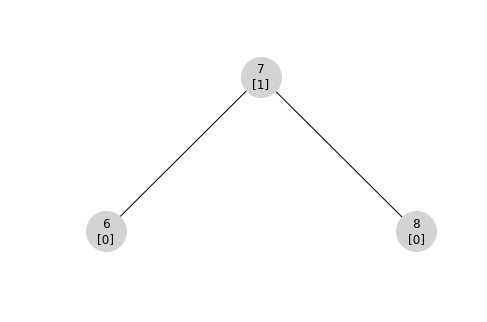

In [13]:
st3.draw()

In [14]:
st3

[[7 6 8][6 . .][8 . .]]

## Walk Test

True True 0 19
0 2 3 4 5 8 9 10 13 14 17 18 19
19 18 17 14 13 10 9 8 5 4 3 2 0


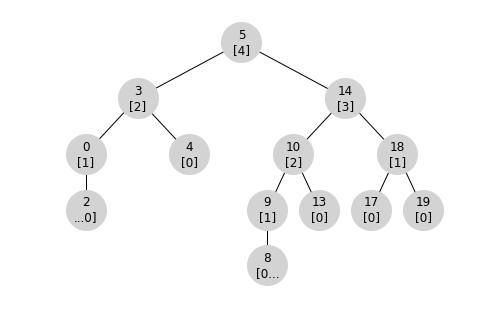

In [15]:
def test():
    st1 = AvlTree().add(range(20))
    st1.remove([1,7,11,6,12,15,16,20])
    print(st1.is_valid, st1.is_balanced, st1.min, st1.max)
    res = [0]
    while res[-1] is not None:
        res.append(st1.next(res[-1]))
    res.pop()
    print(*res)
    res = [res[-1]]
    while res[-1] is not None:
        res.append(st1.prev(res[-1]))
    res.pop()
    print(*res)
    st1.draw()

test()